# Teaching AI Vision models to cry "Werewolf"
## Ollama - LLaVA and Dolphin-Mistral

- when I first started testing Vision AI capabilities across several platforms, I ran into what has been labeled as a "known limitation" - it's difficulty in being able to spot the difference between fact and fiction for similar images
- the first generation of the prompt that I created could tell the difference between a wolf and a werewolf referred to sketching techniques and anatomical ratios.
- the current generation is intended for more general "initial analysis" in a multi-agent workflow, but still works well in spotting the difference between a wolf and a werewolf.
  - In terms of the ability of the current prompt to spot the difference between the wolf and werewolf I believe it is due to the "step by step" nature of the prompt.
- the last example in the Notebook focuses on what I believe is a more valuable usecase, which is medical imaging.

A great use case for LangGraph, with this prompt being used for initial analysis and specialized agents / nodes being used for detailed analysis.

## Jupyter Notebook Setup

In [1]:
%pip install --upgrade --quiet  langchain langchain_community langchain_core pillow


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Enable LangSmith

In [2]:
import os
import uuid, datetime

uid = uuid.uuid4().hex[:6]
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

project_name = f"ollama_image_classification_{current_time}"
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]=project_name

## Image Summarization function

In [3]:
import base64
import imghdr
import os
import requests

from langchain_core.messages import HumanMessage
from langchain_community.chat_models import ChatOllama

def encode_image_from_file(image_path: str) -> str:
    """Encode image to a base64 string from a given file path."""
    try:
        if imghdr.what(image_path) is not None:
            with open(image_path, "rb") as image_file:
                encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
                return encoded_image
        else:
            return "Provided file is not a valid image."
    except FileNotFoundError:
        return "Error: Image file not found."
    except Exception as e:  # Catching broader exceptions for unexpected errors
        return f"Error reading the image file: {e}"

def encode_image_from_url(image_url: str) -> str:
    """Encode image to a base64 string fetched from a URL."""
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        encoded_image = base64.b64encode(response.content).decode('utf-8')
        return encoded_image
    except requests.exceptions.HTTPError:
        return f"Error: HTTP request failed with status code {response.status_code}."
    except requests.exceptions.RequestException:
        return "Error: Failed to fetch the image due to a network error."

def image_summarize(img_base64: str, prompt: str) -> str:
    """Generate a summary for the given image and prompt using ChatOllama."""
    if not img_base64:
        return "Error: Base64 image data is required."

    try:
        chat = ChatOllama(model="llava:13b")
        image_url = f"data:image/jpeg;base64,{img_base64}"
        msg = chat.invoke([
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": image_url},
                ]
            )
        ])
        return msg.content
    except Exception as e:
        return f"Error: Failed to generate summary due to {e}"

In [4]:
def display_base64_image(base64_image: str, alt_text: str = "Base64 Encoded Image", style: str = "") -> str:
    """
    Display a base64-encoded image in a Jupyter notebook or IPython environment.

    Parameters:
    - base64_image (str): The base64 string of the image.
    - alt_text (str, optional): Alternative text for the image for accessibility. Default is "Base64 Encoded Image".
    - style (str, optional): Additional CSS styling for the image. Example: "width:100px; height:auto;"

    Returns:
    - None
    """
    # Create the full HTML src string
    full_src_str = f"data:image/jpeg;base64,{base64_image}"

    # Generate the HTML to embed the image
    html_str = f'<img src="{full_src_str}" alt="{alt_text}" style="{style}" />'
    return html_str

### Image Summarization Prompt

In [5]:
firstgen_prompt_text = """
*Begin your image analysis by following these steps:*

Initial Impression: Describe your first reaction to the image and the overall mood or emotion it conveys.
Contextual Background: If known, provide any relevant historical, cultural, or artistic context of the image.
Detailed Walkthrough: Use art analysis techniques for a detailed examination of the image, focusing on composition, symbolism, and artistic choices.
Unrealistic and Fantastical Elements: Focus on features that are unrealistic or symbolic, especially in depictions of humans, creatures, or environments. Discuss how they differ from real-life counterparts and their potential meanings.

*Conclude your analysis with:*

- Overall Interpretation: Summarize your comprehensive understanding of the image, integrating the various elements you have analyzed.
"""

In [6]:
analysis_prompt_text = """
Objective: Analyze the image to categorize it and provide a standardized JSON output that includes a comprehensive summary of the initial analysis, ensuring consistency and conciseness for downstream processing.

Process:

1. Visual Inspection:
   - Summarize the primary visual content, noting prominent features such as objects, scenes, figures, or text.
2. Contextual Clues:
   - Note any context-specific elements indicating the image's purpose or origin.
3. Image Type Identification:
   - Classify the image into one of the predefined categories: `Artwork`, `Real-life Photograph`, `Business-related`, `Medical`, `Other`.
4. Intended Audience:
   - Speculate on the intended audience based on content and style.
5. Initial Interpretation:
   - Provide a brief interpretation of the image's conveyed or represented content.
6. Special Attention Elements:
   - Highlight elements requiring special attention in detailed analysis.
7. Recommendation for Specialized Analysis:
   - Indicate if the image is recommended for further analysis by a specialized tool.

Output Structure:

```json
{
  "imageType": "Category",
  "visualInspectionSummary": "Summary of the primary visual content.",
  "contextualClues": "Noted context-specific elements.",
  "intendedAudience": "Speculated audience.",
  "initialInterpretation": "Brief interpretation of the image content.",
  "specialAttentionElements": "Elements needing special attention.",
  "recommendedForDetailedAnalysis": true/false,
  "additionalDetails": {
    "potentialConcerns": "Any potential concerns for detailed analysis.",
    "comparativeAnalysis": "Comparative notes if applicable."
  }
}
```

Guidelines for Analysis:

- Ensure all fields are included in every output, using `null` or `"N/A"` for non-applicable sections.
- Adhere to the uniform naming conventions and predefined categories.
- Provide clear, concise descriptions and summaries to facilitate easy understanding and processing by downstream systems.
- Conduct automated validation checks to confirm adherence to the standardized format before submission.
"""

## Wolf image analysis

- use LangChain and Vision models to describe the image


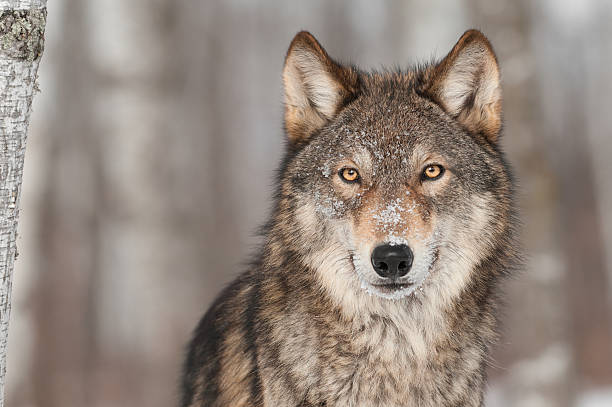

In [7]:
import requests
from IPython.display import display, HTML

image_url = "https://media.istockphoto.com/id/177794699/photo/grey-wolf-portrait.jpg?s=612x612&w=0&k=20&c=vEUo0UKAKeCIIm35zU0zR7XDOf-4AKXvJWLZGx4BVws="

encoded_image = encode_image_from_url(image_url)

display(HTML(display_base64_image(encoded_image)))


### Vision Model Image Summarization code

#### Image Analysis

In [8]:
firstgen_result = image_summarize(encoded_image, firstgen_prompt_text)

In [9]:
print(firstgen_result)

 Initial Impression: The image shows a wolf with striking yellow eyes, standing in a forested area covered with snow. The wolf's fur appears thick and well-adapted to cold weather conditions. It looks directly into the camera, giving an impression of curiosity or attentiveness.

Contextual Background: Wolves are often associated with strength, independence, and wildness. They are also considered symbols of survival and resilience in various cultures. The presence of snow suggests that the photo was taken during a colder season, perhaps winter, which is typical for wolves' habitat.

Detailed Walkthrough:
Composition: The wolf is positioned centrally within the frame, which emphasizes its importance and draws attention to its powerful gaze. The background features trees and snow, creating a naturalistic setting that complements the wolf's wild nature.
Symbolism: Wolves are often seen as symbols of strength, loyalty, and determination in various mythologies and folklore. In this image, th

In [10]:
analysis_result = image_summarize(encoded_image, analysis_prompt_text)

In [11]:
print(analysis_result)

 ```json
{
  "imageType": "Artwork",
  "visualInspectionSummary": "Close-up of a wolf's head with striking eyes, looking directly at the camera.",
  "contextualClues": "No overt context clues provided by image.",
  "intendedAudience": "Animal lovers or those interested in wildlife artwork.",
  "initialInterpretation": "The wolf appears to be captured mid-stare, suggesting a sense of alertness and possibly a connection with the viewer.",
  "specialAttentionElements": "The eyes are particularly noteworthy for their intensity and the wolf's expression.",
  "recommendedForDetailedAnalysis": false,
  "additionalDetails": {
    "potentialConcerns": "There is no visible text or action within the image to raise further concerns.",
    "comparativeAnalysis": "The image does not provide information to compare with other similar images."
  }
}
```


#### Stable Diffusion Prompt

- create a Stable Diffusion Prompt based on the image analysis

In [12]:
from langchain_community.chat_models import ChatOllama

# llm = ChatOllama(model="llama2")
llm = ChatOllama(model="dolphin-mistral")
# llm = ChatOllama(model="dolphin-mixtral")

result = llm.invoke(f"""Create a Stable Diffusion prompt to generate an image for {analysis_result}.
                        Keep the prompt concise by using industry terminology.  The prompt should be less than 77 tokens.
                        Describe the image as if it already exists""")
print(result.content)

 Generate an image of a detailed, close-up portrait of a wolf, with a piercing and intense gaze directly at the viewer, emphasizing its striking eyes and suggesting a sense of alertness and connection. Focus on the naturalistic beauty of its fur texture, as well as the wolf's realistic facial features, capturing its likeness as a symbol of wilderness and admiration for animal lovers or those interested in wildlife artwork. Ensure that no additional context is present within the image to avoid any potential misunderstandings.


## Werewolf image analysis

- use LangChain and Vision models to describe the image


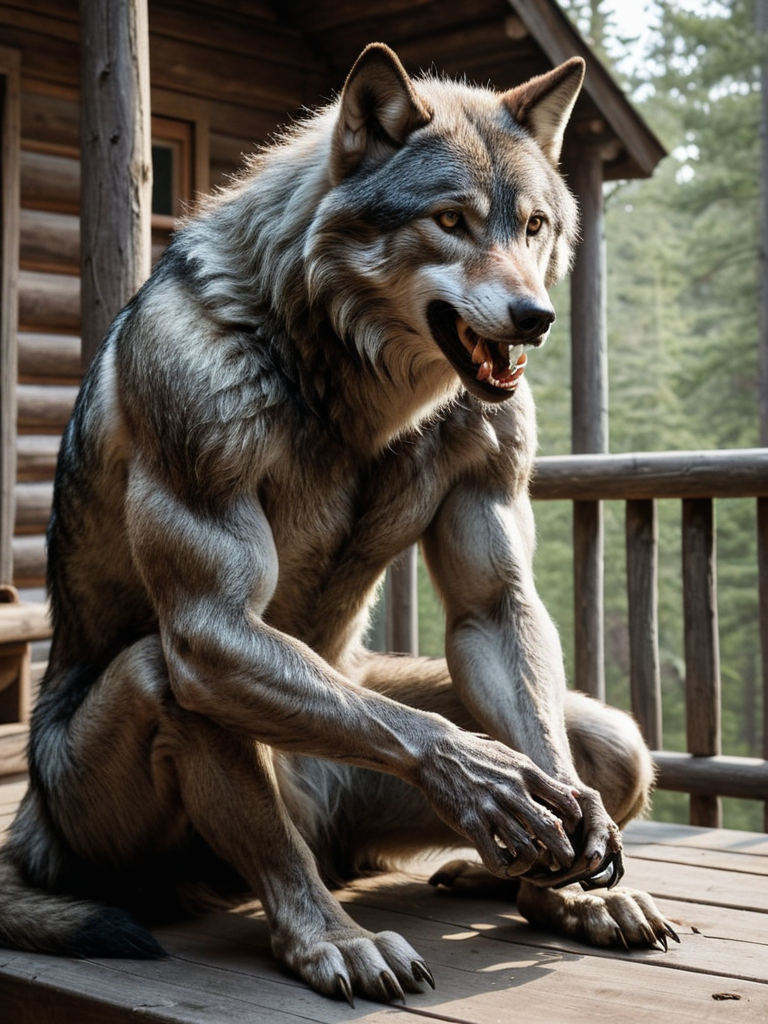

In [13]:
import requests
from IPython.display import display, HTML

image_url = "https://image.civitai.com/xG1nkqKTMzGDvpLrqFT7WA/cc4245f5-588a-462e-97be-da2a4f7b210b/original=true/00093-1169062797.jpeg"

encoded_image = encode_image_from_url(image_url)

display(HTML(display_base64_image(encoded_image)))

### Vision Model Image Summarization code

#### Image Analysis

In [14]:
encoded_image = encode_image_from_url(image_url)
firstgen_result = image_summarize(encoded_image, firstgen_prompt_text)

In [15]:
print(firstgen_result)

 **Initial Impression:**
The image depicts a wolf sitting on wooden steps. The wolf's intense gaze and the surrounding natural environment give it an air of fierceness, which is often associated with wolves in popular culture due to their reputation as formidable predators. The setting appears serene, possibly indicating that the wolf is a resident or guardian of this forest area.

**Contextual Background:**
Wolves are known for their pack behavior and social structure. They were once prevalent across North America, Europe, and Asia but have been hunted to near-extinction in many areas. Efforts at conservation have resulted in some increases in wolf populations in certain regions. Wolves are also often found in mythology and folklore as symbols of strength, courage, and independence.

**Detailed Walkthrough:**
1. **Composition:** The wolf is positioned on the steps, which creates a sense of depth in the image. This arrangement draws the viewer's eyes from the foreground (the steps) to 

In [16]:
analysis_result = image_summarize(encoded_image, analysis_prompt_text)

In [17]:
print(analysis_result)

 ```json
{
  "imageType": "Artwork",
  "visualInspectionSummary": "A wolf sitting on a wooden deck, looking out onto the forest",
  "contextualClues": "The image depicts a realistic portrayal of a wolf in a natural setting, suggesting it may be an artwork meant to capture the beauty and majesty of wildlife.",
  "intendedAudience": "Nature enthusiasts or those interested in wildlife and nature conservation",
  "initialInterpretation": "The image conveys a sense of tranquility and connection with the natural world, showcasing the wolf as an integral part of its environment.",
  "specialAttentionElements": "The details on the fur texture, the pose of the wolf, and the interaction with its surroundings",
  "recommendedForDetailedAnalysis": true,
  "additionalDetails": {
    "potentialConcerns": "An analysis of the artist's intent in portraying this species, any potential biases or accuracy issues",
    "comparativeAnalysis": "Comparisons to other artwork depicting wolves, wildlife, or natu

#### Stable Diffusion Prompt

- create a Stable Diffusion Prompt based on the image analysis

In [18]:
from langchain_community.chat_models import ChatOllama

# llm = ChatOllama(model="llama2")
llm = ChatOllama(model="dolphin-mistral")
# llm = ChatOllama(model="dolphin-mixtral")

result = llm.invoke(f"""Create a Stable Diffusion prompt to generate an image for {analysis_result}.
                        Keep the prompt concise by using industry terminology.  The prompt should be less than 77 tokens.
                        Describe the image as if it already exists""")
print(result.content)

 A highly detailed and lifelike artwork featuring a wolf posed on a wooden deck, gazing out onto a dense forest backdrop, capturing the essence of harmony between the wild creature and its surroundings. The realistic portrayal of fur texture and pose is complemented by the immersive backdrop of natural elements, inviting viewers to appreciate the beauty and importance of nature conservation. This piece would be particularly appealing for nature enthusiasts or those interested in wildlife and ecological preservation.


## Medical Image Analysis

- and now for something completely different...
- looking at a medical and life sciences use case for LangChain and Vision models to describe an image
- it does remarkably well, considering at this point this is just the generic LLaVA model with a generic system and image classification prompt


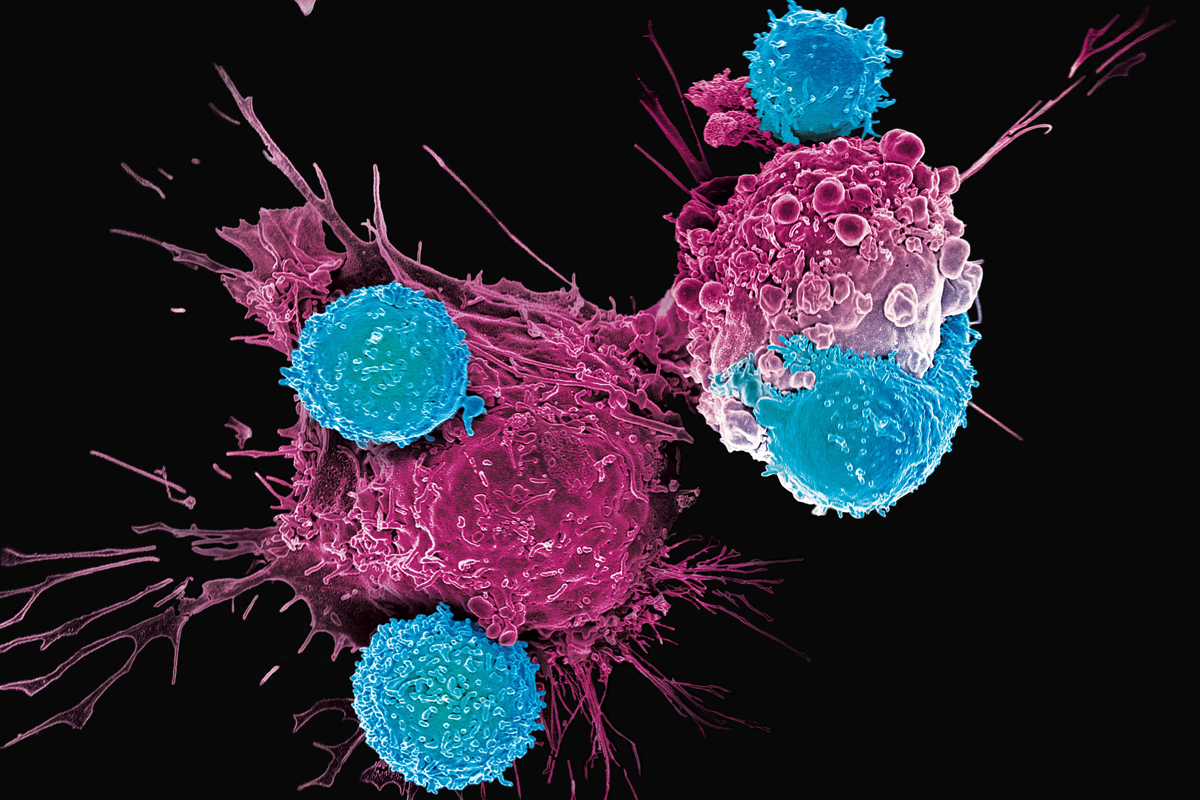

In [19]:
import requests
from IPython.display import display, HTML

image_url = "https://www.mskcc.org/sites/default/files/paragraph/1504/image/adusumillia-car_0_3x2.jpg"

encoded_image = encode_image_from_url(image_url)

display(HTML(display_base64_image(encoded_image)))

### Vision Model Image Summarization code

#### Image Analysis

In [20]:
encoded_image = encode_image_from_url(image_url)
firstgen_result = image_summarize(encoded_image, firstgen_prompt_text)

In [21]:
print(firstgen_result)

 Initial Impression: The image depicts a scientific illustration of a cancer cell, highlighting the complexity and microscopic nature of this form of biological life. It conveys a sense of intricate detail and precision, showcasing the molecular components within the cell.

Contextual Background: Cancer cells are known for their ability to grow uncontrollably and invade healthy tissues. This image represents a visual representation of the cellular and molecular structures that allow cancer to progress. It likely serves an educational purpose, illustrating how such cells function at a microscopic level.

Detailed Walkthrough: The composition of this image is based on scientific knowledge of cancer cells. At the center, there are two large tumor cells in pink and purple hues, indicating different types or stages of the cancer cell's development. These central cells have smaller cells surrounding them, symbolizing a rapid growth characteristic of cancer cells.

Surrounding these larger ce

In [22]:
analysis_result = image_summarize(encoded_image, analysis_prompt_text)

In [23]:
print(analysis_result)

 ```json
{
  "imageType": "Artwork",
  "visualInspectionSummary": "The image depicts a close-up view of cells, with prominent features such as cellular structures and fluorescent markers indicating cancerous cells.",
  "contextualClues": "There are no overt context-specific elements in the image that would indicate its purpose or origin beyond medical or scientific analysis.",
  "intendedAudience": "The intended audience appears to be a medical professional, such as a pathologist or oncologist, due to the specific nature of the depicted cells.",
  "initialInterpretation": "The image is likely a microscopic view of cancerous cells, possibly used for diagnostic purposes or research into cancer biology.",
  "specialAttentionElements": "There are various colored markers on and around the cells, which indicate different aspects of the cellular environment or specific targets for treatment or further study.",
  "recommendedForDetailedAnalysis": true,
  "additionalDetails": {
    "potentialCo

#### Stable Diffusion Prompt

- create a Stable Diffusion Prompt based on the image analysis

In [24]:
from langchain_community.chat_models import ChatOllama

# llm = ChatOllama(model="llama2")
llm = ChatOllama(model="dolphin-mistral")
# llm = ChatOllama(model="dolphin-mixtral")

result = llm.invoke(f"""Create a Stable Diffusion prompt to generate an image for {analysis_result}.
                        Keep the prompt concise by using industry terminology.  The prompt should be less than 77 tokens.
                        Describe the image as if it already exists""")
print(result.content)

 Generate a high-resolution, detailed microscopic image of cancerous cells, specifically depicting various cellular structures and fluorescent markers to identify different cell types or targeted treatments. Focus on a close-up view of these abnormal cells within their environment, highlighting the distinct morphological characteristics and colors associated with cancer progression. Suitable for medical professionals, such as pathologists or oncologists, for research and diagnostic purposes. Additionally, include various colored markers to indicate different aspects of the cellular environment or specific targets for treatment or further study, which would be recommended for detailed analysis and comparative study with other similar images.
